In [1]:
## Own library
from BackBone.preprocessing import loader
from BackBone.model import model_validation, model_epsilon 
from BackBone.tools import output, model_viz, Input_tools
from BackBone import config as cfg

In [2]:
##### Standard python packages
import pandas as pd
import itertools
import numpy as np
import os
from pathlib import Path, PosixPath
import time
import math
import gurobipy as gp
from gurobipy import GRB

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Plot imports
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set_style("darkgrid")
from matplotlib import cm, colors

plt.rcParams.update({'font.size': 13})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rcParams["figure.figsize"] = (10,7)

### Configuring paths and loading input data
To make the code architecture organised a configuration file is created where some key paths are defined. A package called loader has a function "configure_paths" which is configuring all paths needed with a given input file. As the input file contains many years of data a specific year should also be provided. 

When the function "configure_paths" runs it configures all paths for the given input data and makes sure everything is placed in the right folders and takes data from the right folders. Many of the data processing algorithms made for this project takes much time to run, and therefore the output files are pickled. The whole library "Backbone" depends on this configuration. The reason for the setup being like this is to increase the speed of working with the data by having pickle files in specific locations that are quickly read by the computer.

The function "load_input" from loader processes the input data or reads a pickle file if it already knowns the data. 

In [ ]:
## Providing input filename and year
filename = "Input_data_file.xlsx"


## Configuring paths
loader.configure_paths(filename)

In [5]:
## Loading data, given the desired start week and the time horizon of the planning 
data = loader.load_input(start_week = 46, included_weeks = 7)

Loading input data from pickle.
Loading cust_prod from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_customer_product.pickle
Loading cust_prod_time from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_customer_product_time.pickle
Loading site from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_site.pickle
Loading site customer product from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_site_cust_prod.pickle
Loading site to customer from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_site_customer.pickle
Loading product_variant from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_product_variant.pickle
Loading product_variant from pickle: c:\Users\JHIV\OneDrive - 

### Pareto optimisation

To be able to built and test alot of scenarios while having a decent overview the model buiding is placed in a package called "model_epsilon". It contains a function called "build_model" where the code for building the capacity allocation model are placed. It depends on the configuration that we ran above such that it can find the files needed for building a model. 

The baseline model (1Iteration) is built below using "build_model" which returns an lp-file in a configured location. Afterwards "read_model" is executed which solves the model (or reads a solution if it has already been solved). 
Follwong, the pareto optimisation (EpsilonConstraint) will build and solve the model iterativly depenidng on the termination criteria epsilon.

The epsilon constraind optimisaiton follows the pseudo code presented in the report

At last the function "excel_output" takes the solution and creates an overview of the solution in excel. It is a spreadsheet which different sheets that both gives information which product variants are prioritised and what the performance is of each iteration. furthermore, the output containts a sheet of each iterations objective values and the relevant input data for the specific scenario. 


In [6]:
# initializing model
model_epsilon.model_build(model_type = '1Iteration', lp_filename= "model.lp",start_week = 46, included_weeks=7, delta1 = None, delta2 = None, iteration=1)
epsilon_vars = model_epsilon.read_model(cfg.MODEL_PATH, '1Iteration', 1)
variable_df = output.exportDecisionVariables(epsilon_vars,1)
result_1 = output.solution_PM(epsilon_vars)

stop_condition = math.ceil((result_1[0] - result_1[1])*0.85)
j = result_1[0]
o = result_1[1]
epsilon = 0.5
i=2

results = [result_1]
while j-o > stop_condition: 
    model_epsilon.model_build(model_type = 'EpsilonConstraint', lp_filename= "model.lp",start_week = 46, included_weeks = 7,  delta1 = j, delta2 = o, iteration=i)
    epsilon_vars = model_epsilon.read_model(cfg.MODEL_PATH, 'EpsilonConstraint', i)
    variables = output.exportDecisionVariables(epsilon_vars,i)
    result = output.solution_PM(epsilon_vars)
    print(i, ' ', result, ' j: ', j)

    variable_df = pd.concat([variable_df,variables], axis=0)
    results.append(result)

    j -= epsilon
    i += 1


Using pickle files from: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file
___________________________________________________________________________________________
______________FILE WITH THIS NAME ALREADY EXIST______________
___________________________________________________________________________________________
Set parameter CSManager to value "http://appdkba2221.corp.novocorp.net:61080"
Set parameter CSAPIAccessID
Set parameter CSAPISecret
Compute Server job ID: d212a3f3-6c14-4365-8bbb-6b8701522be4
Capacity available on 'APPDKBA2221' - connecting...
Established HTTP unencrypted connection




_________________________________________________
_________________READING LP FILE__________________
_____________________1Iteration1_____________________

Read LP format model from file c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Draft\Input_data_file_1Iteration1_model.lp
Reading time = 0.04 seconds
: 2213 rows, 2586 columns, 6021 nonzeros
________

In [7]:
# Saving objectives values of all iterations to a DataFrame
results_df = output.paretooptimal(results)

In [8]:
# Export objective values, variables and relevant input data to excel
output.excel_output(variable_df, results_df, 'Scenario3')

Output file already exists.


### Validating model solution

The solution the the scenario is run through a validation sript "model_validation" to ensure all iterations are feasible.

In [9]:
# Validate solutions
model_validation.model_validation(variable_df)

x and y constraints are satisfied
service level according to safety stock is satisfied
v and q relation is satisfied
the capacity constraint is satisfied
The demand constraint is satisfied


### Key solution metrics and overviews

The KPI for the performance across all iterations in scenario, by using the "output" 

In [10]:
# Print the KPI for the performance across all iterations in scenario
output.solution_kpis(variable_df, results_df)

-------- KPIs for scenario comparison -----------------
Service level:  
         first:        238.98
         last:         204.48
         Optimal:      238.48
Revenue:  
         first:        54825888
         last:         64042127
         Optimal:      55468647
Average utilisation:  
         first:        0.9964
         last:         0.99796
         Optimal:      0.99665
Average utilisation:  
         first:        mean:  0.85   std:  0.424
         last:         mean:  0.721   std:  0.504
         Optimal:      mean:  0.853   std:  0.456


### Visualizing the characteristics of teh scneario solutions
The below blots will visualised the performance on the four performence measures, individually and in relation to each other

As all scenario results are saved in seperate excel files, the scenario in scope must be defined

In [16]:
# Define scenario in scope

Scenario = 'Scenario3'
variable_df,  capacity, results_df = loader.output_loader(name=Scenario)

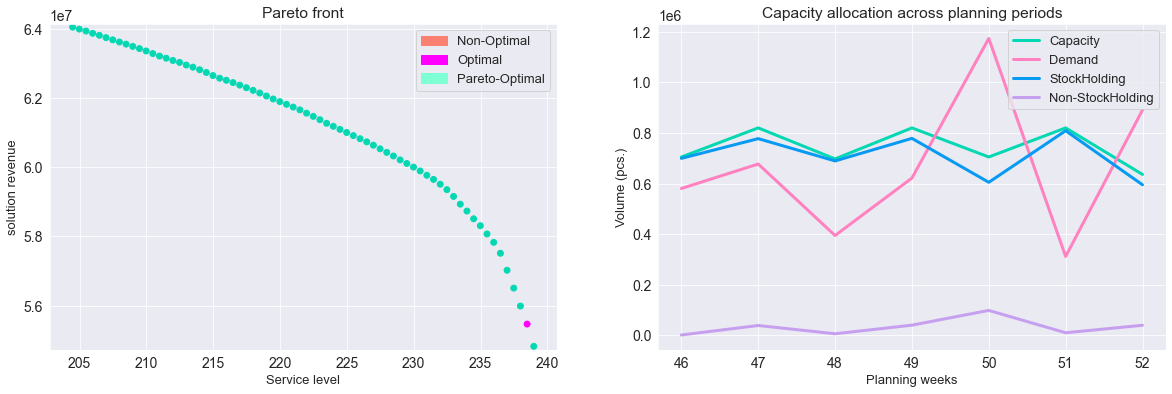

In [19]:
# Plot: pareto pront and scenario charateristics

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,6))

model_viz.paretofront(results_df,fig, ax[0])
model_viz.capacity_allocation_split(variable_df,capacity, optimal, fig,ax[1])

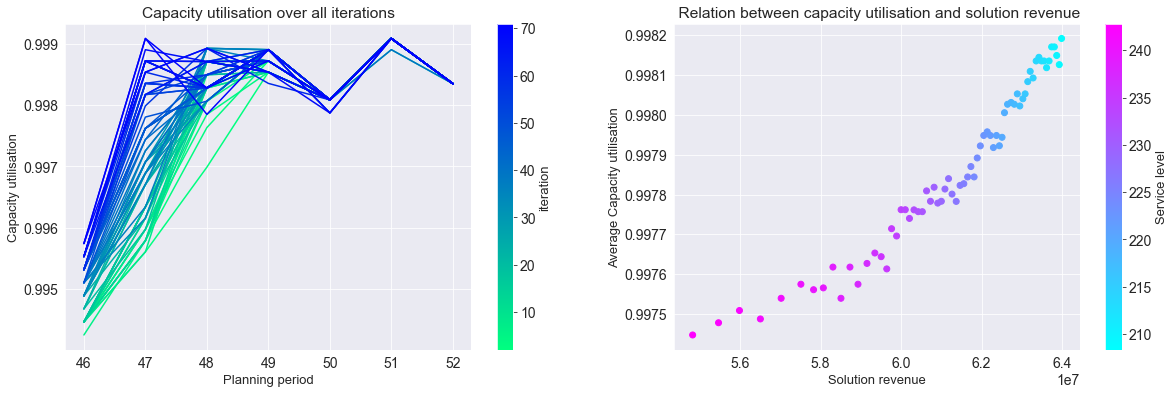

In [20]:
# Plot: the capacity utilisation, revenue and serviece level across planning periods and iteraiotns

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,6))

model_viz.cap_utilisation(variable_df, fig, ax[0])
model_viz.util_profit(variable_df,results_df, fig, ax[1])

3.892100360576923


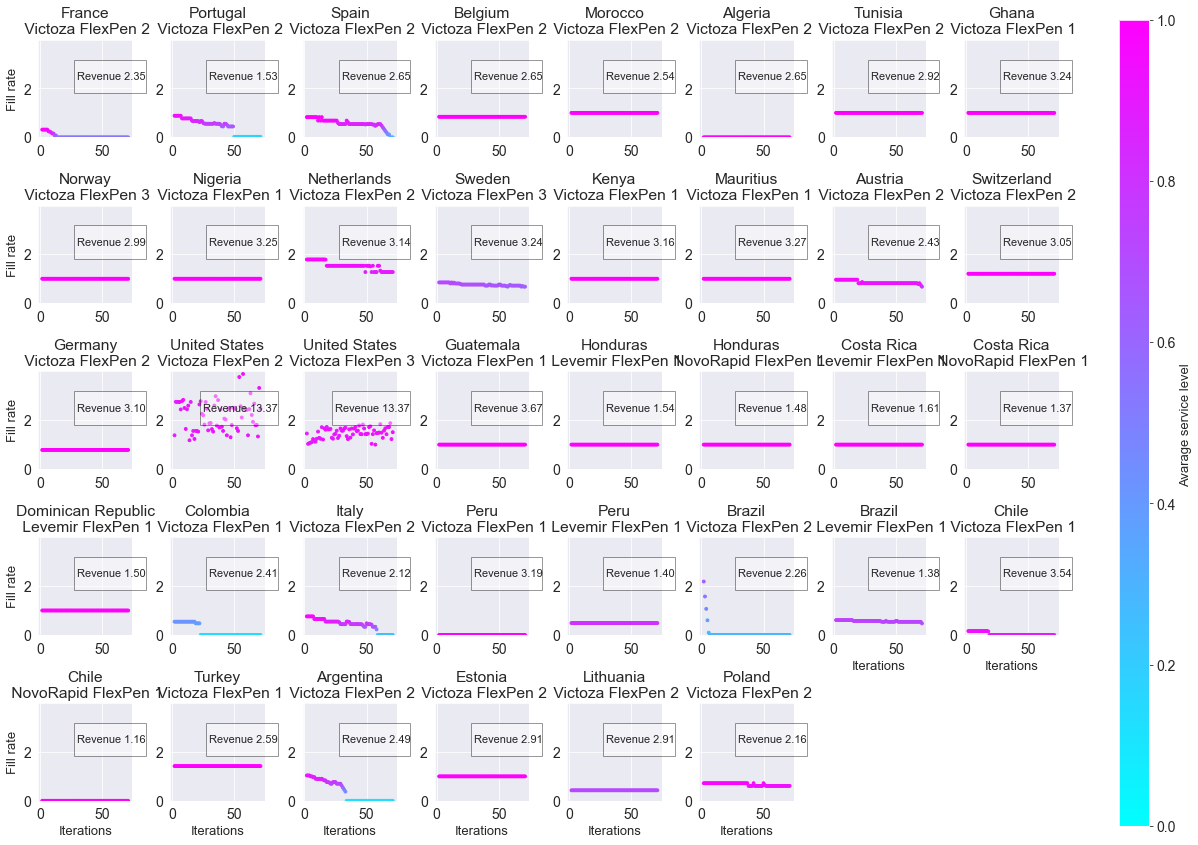

In [22]:
# Plot: ORder fulfillment of product variants from stockholding affiliates with upcomming orders

model_viz.demand_fulfillment_dev1(variable_df)

## Comparison of scenario through visualisation of the Pareto fronts and KPIs

This section performance a comparinson across all scenarios, hence the excel file of all scenarios are loaded. 

In [ ]:
# Import solution data for all scenarios

var_merged, cap_merged, result_merged = loader.output_loader_all()

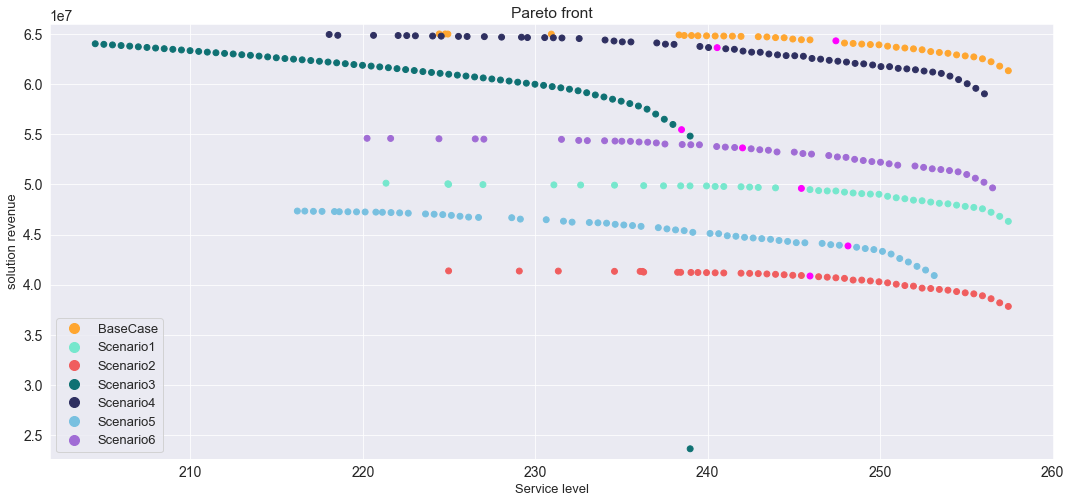

In [16]:
# Plot: Pareto front for each of the scenarios

plt.rcParams["figure.figsize"] = (18,8)
model_viz.pareto_compare(result_merged)

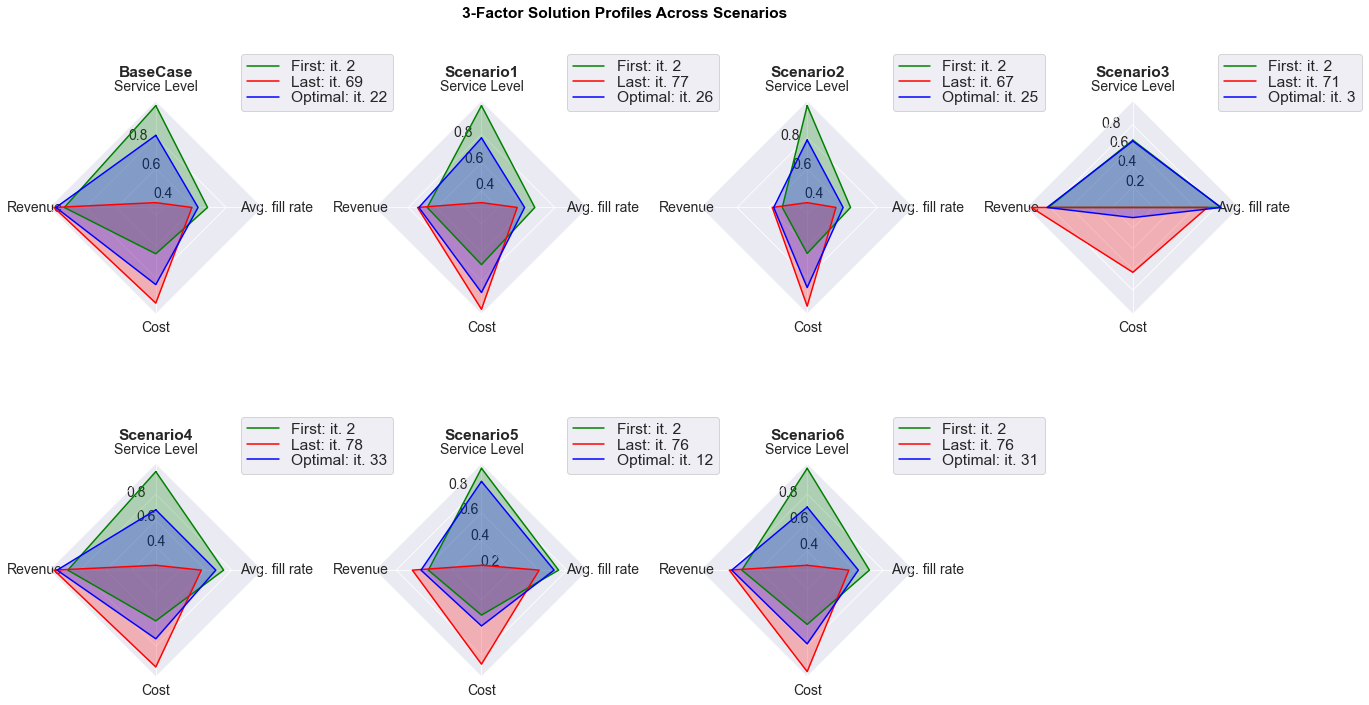

In [24]:
# Plot: The performance measured for the first, last and optimal not pruned solution in each of the scenarios, visualised as standardised measured in radar plots

N = 4
theta = radar_factory(N, frame='polygon')
fig, ax = plt.subplots(figsize=(22, 10), nrows=2, ncols=4,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.3, hspace=0.7, top=0.85, bottom=0.05)

fig.text(0.5, 0.965, '3-Factor Solution Profiles Across Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

model_viz.norm_resutls2(var_merged, result_merged, 'BaseCase', ax[0,0], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario1', ax[0,1], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario2', ax[0,2], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario3', ax[0,3], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario4', ax[1,0], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario5', ax[1,1], fig)
model_viz.norm_resutls2(var_merged, result_merged, 'Scenario6', ax[1,2], fig)
ax[1,3].set_visible(False)